# Text Clustering & Topic Modeling of Pathway Student Questions

This notebook demonstrates how to cluster and explore **student questions** using modern NLP techniques, including embeddings, dimensionality reduction, clustering, and topic modeling.

---

---

This notebook demonstrates clustering and topic modeling for **student questions** using:
- Embeddings
- Dimensionality reduction
- Clustering
- Topic modeling

The workflow is designed for educational data analysis and visualization.

---

> **Note:** Unlike the original notebook (which used arXiv paper titles and abstracts), this workflow uses a custom dataset of student questions stored in a `.txt` file.

### Workflow Steps

1. Convert questions into embedding vectors
2. Reduce embeddings to 5 dimensions
3. Cluster the reduced embeddings
4. Generate keyword-based topics
5. Reduce embeddings to 2 dimensions for visualization
6. Visualize questions and topics
7. Use OpenAI to generate short topic labels

## Setup & Install Dependencies

In [ ]:
!pip install bertopic datasets openai datamapplot

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.0/153.0 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.5/163.5 kB 16.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 48.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 58.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 38.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 44.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.3/244.3 kB 21.8 MB/s eta 0:00:00
  Created wheel for Pyqtree: filename=Pyqtree-1.0.0-py3-none-any.whl size=5969 sha256=db93c460404252dbf2bf482490359cef3c93ebb2613910103acba0a66386f284
  Stored in directory: /root/.cache/pip/wheels/86/02/24/506ac193949f48c8bec599b613d722bd64a83063a190b3bff7
Successfully built Pyqtree
  Attempting uninstall: dask
    Found exist

## Load Dataset

Use the file upload method to flexibly and reliably select the latest dataset of student questions from your computer. This avoids hardcoding file paths or filenames.

In [ ]:
from google.colab import files

# Upload the local dataset file (choose the latest extracted_user_inputs_<date>.txt)
uploaded = files.upload()

# Get the uploaded file name
filename = list(uploaded.keys())[0]

# Load questions from the uploaded file
with open(filename, "r", encoding="utf-8") as f:
    questions = [line.strip() for line in f if line.strip()]

print(f"Loaded {len(questions)} questions")
print("Sample:", questions[:5])


Saving extracted_user_inputs_08_23_25.txt to extracted_user_inputs_08_23_25 (1).txt
Loaded 2900 questions
Sample: ['{"args": [], "kwargs": {"data": {"messages": [{"role": "user", "content": "what do i do if information is incorrect", "annotations": null, "trace_id": null}, {"role": "assistant", "content": "If you find that information is incorrect, the first step is to verify the specific details that need correction. For students, they can update their personal information through the Student Portal, where they can change details such as their preferred name, addresses, phone number, and more [^5]. \\n\\nIf the incorrect information pertains to a grade, students should contact their instructor via Canvas to discuss the issue and request a grade change if necessary [^2]. \\n\\nFor any issues related to Church membership status or account details, students should reach out to their ward or branch clerk for assistance [^8]. \\n\\nIf you are a service missionary and encounter incorrect in

## Create Embeddings
We will use a **sentence transformer** to embed each question into a high-dimensional vector

In [ ]:
from openai import OpenAI
import numpy as np
from google.colab import userdata
from tqdm.auto import tqdm

# Use Colab's secrets manager for API key
client = OpenAI(api_key=userdata.get('OPENAI_API_KEY'))

# Function to generate embeddings in batches
def generate_embeddings_in_batches(client, questions, model="text-embedding-3-large", batch_size=1000):
    embeddings = []
    for i in tqdm(range(0, len(questions), batch_size)):
        batch = questions[i : i + batch_size]
        try:
            response = client.embeddings.create(
                model=model,
                input=batch
            )
            embeddings.extend([d.embedding for d in response.data])
        except Exception as e:
            print(f"Error processing batch {i//batch_size}: {e}")
            # Depending on the error, you might want to implement retry logic or skip the batch
            continue
    return np.array(embeddings)

# Generate embeddings with OpenAI in batches
embeddings = generate_embeddings_in_batches(client, questions)

# Check the dimensions of the resulting embeddings
embeddings.shape

  0%|          | 0/3 [00:00<?, ?it/s]

(2900, 3072)

## Reduce embeddings to 5 dimensions (for clustering)

In [ ]:
from umap import UMAP

# Reduce from 3072 → 5 dims
umap_model = UMAP(
    n_components=5,
    min_dist=0.0,
    metric='cosine',
    random_state=42
)
reduced_embeddings = umap_model.fit_transform(embeddings)

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


## Cluster the reduced embeddings

In [ ]:
from hdbscan import HDBSCAN

# Cluster with HDBSCAN
hdbscan_model = HDBSCAN(
    min_cluster_size=50, # tweak if clusters are too small/too many
    metric="euclidean",
    cluster_selection_method="eom"
)
clusters = hdbscan_model.fit_predict(reduced_embeddings)

# How many clusters were found?
len(set(clusters)), np.unique(clusters, return_counts=True)

/usr/local/lib/python3.12/dist-packages/hdbscan/plots.py:448: SyntaxWarning: invalid escape sequence '\l'
  axis.set_ylabel('$\lambda$ value')
/usr/local/lib/python3.12/dist-packages/hdbscan/robust_single_linkage_.py:175: SyntaxWarning: invalid escape sequence '\{'
  $max \{ core_k(a), core_k(b), 1/\alpha d(a,b) \}$.
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


(17,
 (array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15]),
  array([967,  81, 132,  54,  74,  87,  66, 180, 140, 206,  86, 119,  71,
         143, 153, 192, 149])))

## Reduce to 2D for visualization

In [ ]:
import pandas as pd

# Reduce again for visualization (3072 → 2)
reduced_2d = UMAP(
    n_components=2,
    min_dist=0.0,
    metric='cosine',
    random_state=42
).fit_transform(embeddings)

# Create dataframe
df = pd.DataFrame(reduced_2d, columns=["x", "y"])
df["questions"] = questions
df["cluster"] = clusters

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


## Visualize clusters

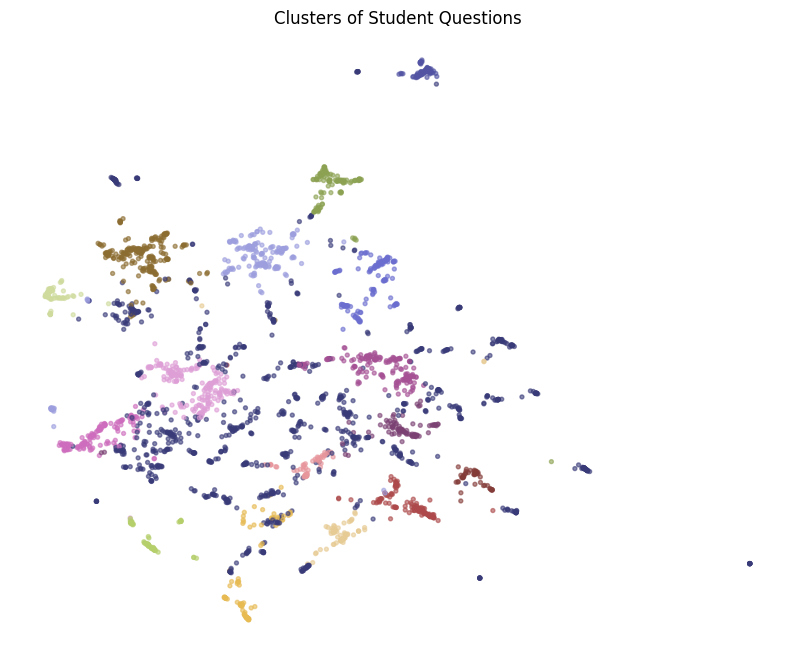

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,8))
plt.scatter(df.x, df.y, c=df.cluster, cmap="tab20b", alpha=0.6, s=8)
plt.title("Clusters of Student Questions")
plt.axis("off")
plt.show()

## Fit BETTopic with your OpenAI embeddings

In [ ]:
from bertopic import BERTopic

# Train our model with our previously defined models
topic_model = BERTopic(
    embedding_model=None, # We already have embeddings
    umap_model=umap_model,
    hdbscan_model=hdbscan_model,
    verbose=True
)

topics, probs = topic_model.fit_transform(questions, embeddings)

topic_model.get_topic_info().head(10)

2025-08-25 13:57:58,953 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-08-25 13:58:36,709 - BERTopic - Dimensionality - Completed ✓
2025-08-25 13:58:36,710 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-08-25 13:58:36,795 - BERTopic - Cluster - Completed ✓
2025-08-25 13:58:36,799 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-08-25 13:58:36,868 - BERTopic - Representation - Completed ✓


,Topic,Count,Name,Representation,Representative_Docs
0,-1,1048,-1_the_to_student_in,"[the, to, student, in, can, my, and, for, what...","[{""args"": [], ""kwargs"": {""data"": {""messages"": ..."
1,0,214,0_english_connect_englishconnect_for,"[english, connect, englishconnect, for, regist...","[How to register for English connect, How to r..."
2,1,193,1_pathway_byu_byupathway_to,"[pathway, byu, byupathway, to, for, connect, h...","[What is Byu pathway, What is BYU-Pathway, Wha..."
3,2,185,2_ec3_register_how_for,"[ec3, register, how, for, learner, does, an, d...","[How to register for EC3, how to register for ..."
4,3,165,3_missionary_service_missionaries_to,"[missionary, service, missionaries, to, traini...","[how to find my missionary email, how to find ..."
5,4,142,4_certificate_completion_pathwayconnect_pathway,"[certificate, completion, pathwayconnect, path...",[How does a student obtain their certificate o...
6,5,135,5_tuition_pay_discount_heber,"[tuition, pay, discount, heber, grant, payment...","[How to pay for tuition?, how to pay for a stu..."
7,6,123,6_gathering_gatherings_how_do,"[gathering, gatherings, how, do, my, change, t...","[My Gathering, My Gathering, My Gathering]"
8,7,118,7_term_2025_dates_when,"[term, 2025, dates, when, start, calendar, dat...","[when does term 5 start in 2025, when does ter..."
9,8,92,8_portal_access_student_canvas,"[portal, access, student, canvas, do, how, the...","[how do i access the student portal, how do i ..."


## Use OpenAI to label topics

In [ ]:
from bertopic.representation import OpenAI

prompt = """
I have a topic that contains the following student questions:
[DOCUMENTS]

The topic is described by the following keywords: [KEYWORDS]

Based on the information above, extract a short topic label in the format:
topic: <short topic label>
"""

representation_model = OpenAI(
    client,
    model="gpt_4o-mini", # or gpt_4o-mini
    exponential_backoff=True,
    chat=True,
    prompt=prompt
)

topic_model.update_topics(questions, representation_model=representation_model)
topic_model.get_topic_info().head(10)

100%|██████████| 17/17 [00:12<00:00,  1.38it/s]


,Topic,Count,Name,Representation,Representative_Docs
0,-1,1048,-1_Student Requests and Assistance on BYU-Idah...,[Student Requests and Assistance on BYU-Idaho ...,"[{""args"": [], ""kwargs"": {""data"": {""messages"": ..."
1,0,214,0_Registering for English Connect 3,[Registering for English Connect 3],"[How to register for English connect, How to r..."
2,1,193,1_Understanding BYU-Pathway Program,[Understanding BYU-Pathway Program],"[What is Byu pathway, What is BYU-Pathway, Wha..."
3,2,185,2_How to register for EC3 and learner particip...,[How to register for EC3 and learner participa...,"[How to register for EC3, how to register for ..."
4,3,165,3_Finding Missionary Email and Service Trainin...,[Finding Missionary Email and Service Training...,"[how to find my missionary email, how to find ..."
5,4,142,4_PathwayConnect Certificate Completion Requir...,[PathwayConnect Certificate Completion Require...,[How does a student obtain their certificate o...
6,5,135,5_Methods of Paying Tuition for Students,[Methods of Paying Tuition for Students],"[How to pay for tuition?, how to pay for a stu..."
7,6,123,6_Student Engagement in Religious Gatherings,[Student Engagement in Religious Gatherings],"[My Gathering, My Gathering, My Gathering]"
8,7,118,7_Academic Term Dates for 2025,[Academic Term Dates for 2025],"[when does term 5 start in 2025, when does ter..."
9,8,92,8_Student Portal Access Instructions,[Student Portal Access Instructions],"[how do i access the student portal, how do i ..."


## Visualizations

In [ ]:
# Interactive doc visualization
fig = topic_model.visualize_documents(
    questions,
    reduced_embeddings=reduced_2d,
    width=1200,
    hide_annotations=True
)
fig.show()

# Keyword barchart
topic_model.visualize_barchart()

# Heatmap of topics
topic_model.visualize_heatmap

# Hierarchical topic structure
topic_model.visualize_hierarchy()